# Introduction

This report is for the Data Science Research Methods assignment, and represents the analysis over the provided dataset, namely the "PAMAP2_Dataset: Physical Activity Monitoring", which contains various activities. The Dataset took input from 9 subjects' chest, ankles and hands to monitor magnetic, inertial and acceleration information. These inertial measurement units (IMU) were taken using devices such as a gyroscope, magnetometer and accelerometer. 

This work has been achieved in Google Colab, in Python, using toolkits and frameworks.


# The aims

The aims of the exercise were to execute real world data analysis tasks on this dataset and come up with insights that a company that produces wearable technology might find the discoveries made by the reasercher useful.

The general intuition from the start was that a company such as Fitbit might want to reduce costs of production of a wearable device so that it could deliver the same results, i.e. prediction of activity and/or denoting the amount of physical exercise that the customer has done in a period of time.

In this investigation we aim to highlight a tradeoff between model accuracy and the number of features used in prediction.



# The content

This report will contain a first phase of setting up the data: collecting it and cleaning the missing data by replacing the nan values, and also deleting certain features that, as instructed in the dataset documents. This includes activity ID 0 as it was a 'transient' activity between other activities.
We also remove the orientation features from each IMU as they were detailed to be invalid in the document. Also removed, was the 6g accelerometer data because as the documents stated it was liable to over-saturation.


Exploratory Data Analysis will be performed with the motivation that was specified in the beginning of the report: we want to find correlations between features to check for redundancy as well as examining feature utility. 
The purpose of this will be to inform wearable technology companies about the trade-off that can be achieved between production cost and product accuracy.

In EDA, we also interpolate missing data in the dataset, most of which comes from the different sampling rate of the heart rate monitor and the IMU sensors. We perform the interpolation per activity, per subject so as not to confound the features.

The remaining missing data is filled using a technique called back-filling, where valid data points are repeated for the invalid data points leading up to it.


During EDA, we will identify the features that correlate strongest with the target, namely the category of activity. The activities in the dataset have been split into categories by Metabolic Equivalent of Task(MET) values. This allows us to simplify the predction task, because we are no longer concerned with the specific activity, and rather the expected exertion.

We also create a new set of features using the IMU sensor data, that using a rolling window sums the sensor data over the last 0.05 seconds. The reason for this is that it is more informative to know a change over a larger window than it is to know the instantaneous change at any timestep.

Next, we investigate the heart rate data and observe that it appears fairly separable over the activity categories. This forms our first hypothesis that we test later on in the document. This hypothesis states that, there will be a mass difference in heart rate values of categories 2 and 3 to category 1 activities, indicating that there is a noticeable difference in heart rate between more exhausting activities. This is validated using a t-test.

In the last part of Data Analysis, we investigate the utility of the temperature feature. Initial investigation shows that there is a difference in temperature between high intensity activities and low intensity activites. we also look at the correlation between heart rate and temperature, and how this varies per sensor location and activity category. It appears they are distinguishable enough to be useful features in prediction.

A machine learning model is trained and tested using a number of sets of features from the dataset. The idea behind this is that we are presenting the theoretical tech company with a variety of features to use in hardware production along with the accuracies resulting in the use of these features. A Logistic Regression model was used and the accuracies are detailed in the section of the model, below. 




# Actionable Insights

There are a number of conclusions we can draw from this investigation that might be helpful for a potential company looking at making fitness technology. The most interesting insights:


*   There is a small difference between predictive capabilities of each subset of training data. The accuracy of the model compared to when using all of the features only decreases by 7.2% for the theoretical watch model and 3.3% for the chest strap model. Both are over 80% accurate.
*   The gyroscope sensor in the IMU correlates strongest with the category of activity, thus making it the most informative IMU feature.


*   IMU sensors such as the Magnetometer and Accelerometer are less informative for activity type


Insight for a potential company would be that they can create an accurate and effective piece of hardware in determining levels of physical exertion from a minimum of sensors and therefore minimal production cost.



# Importing Packages

In [2]:
import pandas as pd
import pandas as pd
import sys
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sn

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score

from sklearn.model_selection import GridSearchCV
import numpy as np
from scipy.linalg import pinv
from scipy.spatial.distance import euclidean, cdist

#from google.colab import drive
import seaborn as sns

In [3]:
sns.set(rc={'figure.figsize':(16,9)})

# Importing Dataset

In [4]:
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
location = '/content/drive/My Drive/Colab Notebooks/dsrm/'

In [6]:
activityIDdict = {0: 'transient',
                  1: 'lying',
                  2: 'sitting',
                  3: 'standing',
                  4: 'walking',
                  5: 'running',
                  6: 'cycling',
                  7: 'Nordic_walking',
                  9: 'watching_TV',
                  10: 'computer_work',
                  11: 'car_driving',
                  12: 'ascending_stairs',
                  13: 'descending_stairs',
                  16: 'vacuum_cleaning',
                  17: 'ironing',
                  18: 'folding_laundry',
                  19: 'house_cleaning',
                  20: 'playing_soccer',
                  24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

hand = ['handTemperature', 
           'handAcc16_x', 'handAcc16_y', 'handAcc16_z', 
           'handAcc6_x', 'handAcc6_y', 'handAcc6_z', 
           'handGyro_x', 'handGyro_y', 'handGyro_z', 
           'handMagne_x', 'handMagne_y', 'handMagne_z',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

chest = ['chestTemperature', 
           'chestAcc16_x', 'chestAcc16_y', 'chestAcc16_z', 
           'chestAcc6_x', 'chestAcc6_y', 'chestAcc6_z', 
           'chestGyro_x', 'chestGyro_y', 'chestGyro_z', 
           'chestMagne_x', 'chestMagne_y', 'chestMagne_z',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

ankle = ['ankleTemperature', 
           'ankleAcc16_x', 'ankleAcc16_y', 'ankleAcc16_z', 
           'ankleAcc6_x', 'ankleAcc6_y', 'ankleAcc6_z', 
           'ankleGyro_x', 'ankleGyro_y', 'ankleGyro_z', 
           'ankleMagne_x', 'ankleMagne_y', 'ankleMagne_z',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + hand + chest + ankle  


# Extraction into pandas



As can be seen in the next code cell, the data was extracted into a Dataframe. Originally, the extraction was done from Google Colaboratory by concatenating the location file and reading table by table into the dataframe, but for the purpose of exporting this file on any machine, we assume the "dat" files to be in the same directory as this notebook so that the code will just append the content of the files into a singular dataframe to be used for the next steps.

In [7]:
df = pd.DataFrame()

In [12]:
for i in range(1,10):
    openi = open(location+'subject10'+str(i)+'.dat')
    table = pd.read_table(openi, header=None, sep='\s+')
    table.columns = columns
    table['subject_id'] = i
    df = df.append(table, ignore_index=True)

df.reset_index(drop=True, inplace=True)


In [ ]:
# use this instead of colab part with location

for i in range(1,10):
    openi = open('subject10'+str(i)+'.dat')
    table = pd.read_table(openi, header=None, sep='\s+')
    table.columns = columns
    table['subject_id'] = i
    df = df.append(table, ignore_index=True)

df.reset_index(drop=True, inplace=True)


# Removal of redundant features


In the dataset documents, they detail a number of features that are redundant. The orientation feature for all IMU's is invalid in this dataset. They also mention that the 6G accelerometers are liable to over saturation when experiencing more than 6G. For this reason these columns will be dropped from the dataset.

In [13]:
toDrop = [
          'handAcc6_x', 'handAcc6_y', 'handAcc6_z',
          'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
          'chestAcc6_x', 'chestAcc6_y', 'chestAcc6_z', 
          'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
          'ankleAcc6_x', 'ankleAcc6_y', 'ankleAcc6_z', 
          'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'
          ]

df.drop(columns=toDrop, inplace=True)

# Adding MET Data

In the data collection protocol of the dataset documents, they specify for each recorded activity what the estimated metabolic equivalent of task (MET) value is. MET can be used to estimate calories burned per minute, and activities can be grouped into broad categories of intensity.

Rather than predicting specifically what activity someone might be doing (ironing, folding laundry, etc.) at a very granular level this research proposes that the classification should be aimed at predicting what intensity the activity that the user is performing.





**Individual differences:**

For a company to make a gadget that measures calories burned, for example, one should take into consideration the individual differences such as height, weight, age etc.
This goes far beyond into anatomy/biology and is outside of the scope of this project.
Nonetheless, the MET data is a good indicator for measuring physical effort.


The generally accepted classifications of MET will now be listed.
Activities with an MET value less than 3 are deemed light intensity activities.
An MET value between 3 and 6 inclusive are deemed moderate intensity activities, whilst an MET value of over 6 indicates vigorous intensity.

We can therefore categorise the activites in the dataset as follows:
- Light intensity activities:
 - Lying down - 1 MET
 - Sitting - 1.8 MET
 - Standing - 1.8 MET
 - Watching TV (sitting or lying down) - MET Unspecified
 - Computer work (sitting or standing) - MET Unspecified
 - Car driving (sitting) - MET Unspecified
 - Ironing (standing) - 2.3 MET
 - Folding Laundry (standing) - MET Unspecified

- Moderate intensity activities:
 - Descending stairs - 3 MET
 - Vacuuming - 3.5 MET
 - Walking - 3.3-3.8 MET
 - Cycling - 4 MET
 - Nordic Walking - 5-6 MET
 - House cleaning (presumed similar to walking and vacuuming)

- Vigorous intensity activities:
 - Running - 7-8 MET
 - Ascending stairs - 8 MET
 - Football (presumed running)
 - Skipping - 8-10 MET


 

In [14]:
light_actIDs = [1, 2, 3, 9, 10, 11, 17, 18]

moderate_actIDs = [4, 6, 7, 13, 16, 19]

vigourous_actIDs = [5, 12, 20, 24]

df['categoryID'] = 0

In [15]:
for id in light_actIDs:
    df['categoryID'].mask(df['activityID'] == id, other = 1, inplace=True)

for id in moderate_actIDs:
    df['categoryID'].mask(df['activityID'] == id, other = 2, inplace=True)

for id in vigourous_actIDs:
    df['categoryID'].mask(df['activityID'] == id, other = 3, inplace=True)



# Checking for NaNs


In the next code run, we can see that the "df" dataframe contains 2.88% NaN values, which will hinder our EDA, as well as hypothesis process and learning process of a prediciton model, so we must carry out the means to impute the Nans with the appropriate technique. 

In [16]:
num_elements = df.shape[0]*df.shape[1]
percent_nans = round(((df.isna().sum().sum()/num_elements) * 100),2)
print(percent_nans,"% of elements in the dataset are NaN values")

2.88 % of elements in the dataset are NaN values


# Handling and cleaning data


This next section deals with cleaning the data that we are going to analyse. Activity ID 0 is to be removed, as it was mentioned in the pdf provided with the dataset that it was a "transitive" feature, and included a mix of data at different time steps.

In [17]:
data = df[df["activityID"] != 0]

In the dataset details it is mentioned that the sampling frequency of the devices differ. The heart rate monitor has a sampling rate of ~9Hz. The IMU devices have a sampling rate of ~100Hz. This is the reason that there are far more NaN values for the heart rate feature than for the IMU columns. As can be seen in the code cell below, there are 90% NaN values for heartrate data, which is due to the sampling rate being 1/10th that of the other measurements.

In [18]:
pct_heartrate_nans = (data["heartrate"].isna().sum() / len(data)) * 100
print(pct_heartrate_nans, "% of rows have NaN values for heartrate")


90.86877570936223 % of rows have NaN values for heartrate


Because of this lack of heartrate data, we must interpolate and remove the missing NaN values.

The dataset provided optional and protocol folders. The protocol folder is the one that will be used throughout this investigation. Because the following activities are missing from the protocol folder, they shall be not be included in the investigation. 

These are detailed in the missing columns list below:

In [19]:
missing_columns = ["watching_TV", "computer_work", "car_driving" "folding_laundry", "house_cleaning", "playing_soccer"]

### Counting NaNs 

As expected, seen below, there are 9% of non-nan values in the heartrate feature. This is because of the sampling rate difference of sensors.

In [20]:
nan_dict = {}
for key,value in activityIDdict.items():
    #Iter through activities, and see if they have 
    #the same portion of nans for heartrate
    temp_dict = data[data["activityID"] == key]
    num_nans = temp_dict.isna().sum()["heartrate"]
    pct_value = ((len(temp_dict) - num_nans) / len(temp_dict)) * 100
    nan_dict[value] = [pct_value]
nan_df = pd.DataFrame(nan_dict)

print("Showing percentage of missing values for heartrate measurements")
nan_df.mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


Showing percentage of missing values for heartrate measurements


transient                 NaN
lying                9.141765
sitting              9.141521
standing             9.134896
walking              9.124606
running              9.049990
cycling              9.139733
Nordic_walking       9.142669
watching_TV               NaN
computer_work             NaN
car_driving               NaN
ascending_stairs     9.136125
descending_stairs    9.141066
vacuum_cleaning      9.140420
ironing              9.120617
folding_laundry           NaN
house_cleaning            NaN
playing_soccer            NaN
rope_jumping         9.145057
dtype: float64

# Interpolating Data and Removing NaN Values

This section will interpolate the data and remove NaN values, as well as creating new feature columns.

**The interpolation**

- The interpolation for this dataset must be performed per subject, per activity. This is essential to make sure that there are not confounding variables by interpolating across activities with very different MET values.



**The new features**

- The new features that are created in this section are related to the data collected from each IMU. These devices collected accelerometer, gyroscope, and magnetometer data for each (x,y,z) direction. 

- Whilst this is useful data in understanding positional change of the device, the numbers on their own are not very useful for prediction. This is because these features need to have some temporal relation to each other. That is to say for example, an accelerometer value of 2G is not as informative as knowing the sum of accelerometer values over the last 0.05 seconds. 

- These new features create a rolling sum of values in each direction x,y,z for each data type of each IMU over the previous 0.05 seconds. This can be done because the sampling rate is 100Hz, i.e 100 samples per second. Therefore we can perform a rolling sum with a window of 5 to get the 0.05 second total. The initial values that do not fit into this window are imputed with the mean of the total column.

In [22]:
#This list contains all the columns that the afore mentioned new features will be created from.
col_changes = [
           'handAcc16_x', 'handAcc16_y', 'handAcc16_z',
           'handGyro_x', 'handGyro_y', 'handGyro_z', 
           'handMagne_x', 'handMagne_y', 'handMagne_z',
           'chestAcc16_x', 'chestAcc16_y', 'chestAcc16_z',
           'chestGyro_x', 'chestGyro_y', 'chestGyro_z', 
           'chestMagne_x', 'chestMagne_y', 'chestMagne_z',
           'ankleAcc16_x', 'ankleAcc16_y', 'ankleAcc16_z', 
           'ankleGyro_x', 'ankleGyro_y', 'ankleGyro_z', 
           'ankleMagne_x', 'ankleMagne_y', 'ankleMagne_z'
           ]

changed_cols = []

for col in col_changes:
    chg_col = col+"_rollsum"
    changed_cols.append(chg_col) 

In [23]:
interp_df = data.copy()

#This creates the new columns for the rolling sum features
for col in changed_cols:
    interp_df[col] = 0

#Iterating through each subject ID
for subjectID in range(1,10):
    print("subject:",subjectID)

    #Iterating through each activity type
    for actID,value in activityIDdict.items():

        #If we have data for this subject and activity
        if value not in missing_columns:
            #Get this data
            temp_dframe = interp_df[interp_df["activityID"] == actID]
            temp_dframe = temp_dframe[temp_dframe["subject_id"]==subjectID]

            #Create the columns in the new data
            for col in col_changes:
                chg_col = col+"_rollsum"
                #This performs the rolling sum to create the new features
                temp_dframe[chg_col] = temp_dframe[col].rolling(5, min_periods=1).sum()

            #This fills in the NaN values for the new rolling sum features
            temp_dframe.fillna(temp_dframe.mean()[changed_cols], inplace=True)

            #This interpolates the rest of the dataset, mostly useful for heartrate data
            temp_dframe = temp_dframe.interpolate()

            #This removes the trailing NaN values in the heartrate data
            temp_dframe.fillna(method="backfill", inplace=True)

            #This adds this generated dataset to the original dataset
            interp_idx = temp_dframe.index
            interp_df.loc[interp_idx] = temp_dframe.loc[interp_idx]

subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9


After performing this operation, there is 1 remaining NaN value, so this row is dropped from the dataset.

In [24]:
print(len(interp_df))
interp_df.dropna(inplace=True)
interp_df.isna().sum()
print(len(interp_df))

1942872
1942871


# Analysing Features

Through feature analysis, it was found that whilst these rolling sum features did not correlate strongly with the activity type on their own, the summed value of these did. This value is created by summing the absolute values in each direction for the IMU rolling sum features.

This creates a sort of total difference combining each direction value that can be used for prediction. The next code cell creates this new feature. 

This also serves the purpose of reducing the state space and removing redundant features.

In [25]:
interp_df["handAcc16_vecsum"] = interp_df["handAcc16_x_rollsum"].abs() + interp_df["handAcc16_y_rollsum"].abs() + interp_df["handAcc16_z_rollsum"].abs()
interp_df["handGyro_vecsum"] = interp_df["handGyro_x_rollsum"].abs() + interp_df["handGyro_y_rollsum"].abs() + interp_df["handGyro_z_rollsum"].abs()
interp_df["handMagne_vecsum"] = interp_df["handMagne_x_rollsum"].abs() + interp_df["handMagne_y_rollsum"].abs() + interp_df["handMagne_z_rollsum"].abs()

interp_df["chestAcc16_vecsum"] = interp_df["chestAcc16_x_rollsum"].abs() + interp_df["chestAcc16_y_rollsum"].abs() + interp_df["chestAcc16_z_rollsum"].abs()
interp_df["chestGyro_vecsum"] = interp_df["chestGyro_x_rollsum"].abs() + interp_df["chestGyro_y_rollsum"].abs() + interp_df["chestGyro_z_rollsum"].abs()
interp_df["chestMagne_vecsum"] = interp_df["chestMagne_x_rollsum"].abs() + interp_df["chestMagne_y_rollsum"].abs() + interp_df["chestMagne_z_rollsum"].abs()

interp_df["ankleAcc16_vecsum"] = interp_df["ankleAcc16_x_rollsum"].abs() + interp_df["ankleAcc16_y_rollsum"].abs() + interp_df["ankleAcc16_z_rollsum"].abs()
interp_df["ankleGyro_vecsum"] = interp_df["ankleGyro_x_rollsum"].abs() + interp_df["ankleGyro_y_rollsum"].abs() + interp_df["ankleGyro_z_rollsum"].abs()
interp_df["ankleMagne_vecsum"] = interp_df["ankleMagne_x_rollsum"].abs() + interp_df["ankleMagne_y_rollsum"].abs() + interp_df["ankleMagne_z_rollsum"].abs()

interp_df.drop(columns = changed_cols, inplace=True)
interp_df.drop(columns = col_changes, inplace=True)


## Analysing Heart Rate Data

The heartrate data seems to be the most intuitive in predicting the intensity of activity. As can be seen in the distributions below, the various categories (light, moderate, vigorous) of activity are fairly separable.

There is some overlap between category 2 and 3. For this reason, we can group category 2 and 3 together as exercise, and then the exercise and non-exercise becomes fairly linearly separable. 

We will use this grouped category later on in the document, when we perform hypothesis testing.

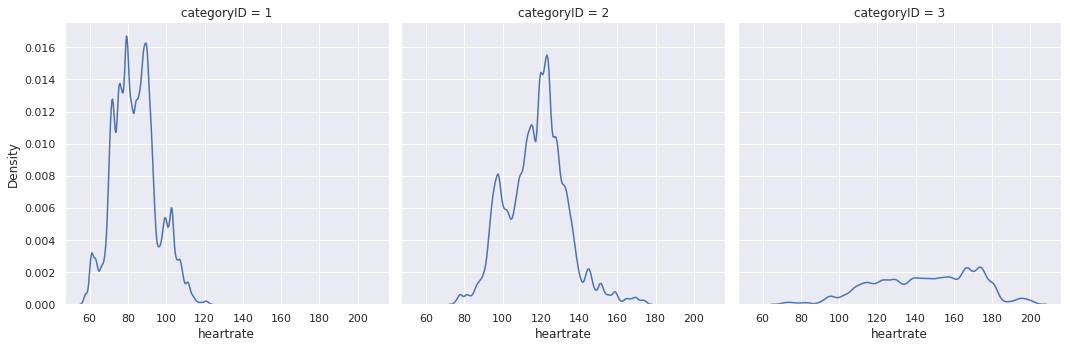

In [26]:
sns.displot(data = interp_df, x = "heartrate", col = "categoryID", kind = "kde")

The table below shows the above graphs being converted to a table format to have a better understanding of the distribution of data.

In [27]:
grouped_df = interp_df.groupby(["activityID","heartrate","categoryID"])["heartrate"].mean().unstack("categoryID")
grouped_df.describe()

categoryID,1,2,3
count,4179.000000,6516.000000,5075.000000
mean,88.432041,117.227746,143.352586
std,13.164187,20.080800,26.667968
min,57.000000,75.000000,71.000000
25%,78.909091,103.200000,124.128788
50%,87.990291,115.700000,143.909091
75%,97.485294,130.600000,163.181818
max,122.000000,175.000000,202.000000


## Example of heart rate change over activity

In this section, we will briefly look at an example of how a specific subject heart rate changes over time throughout a running activity.

In this example, we look at subject 105 running over a duration of 246 seconds.

In [28]:
running_df = interp_df[interp_df["activityID"] == 5]
running_df = running_df[running_df["subject_id"]==5]

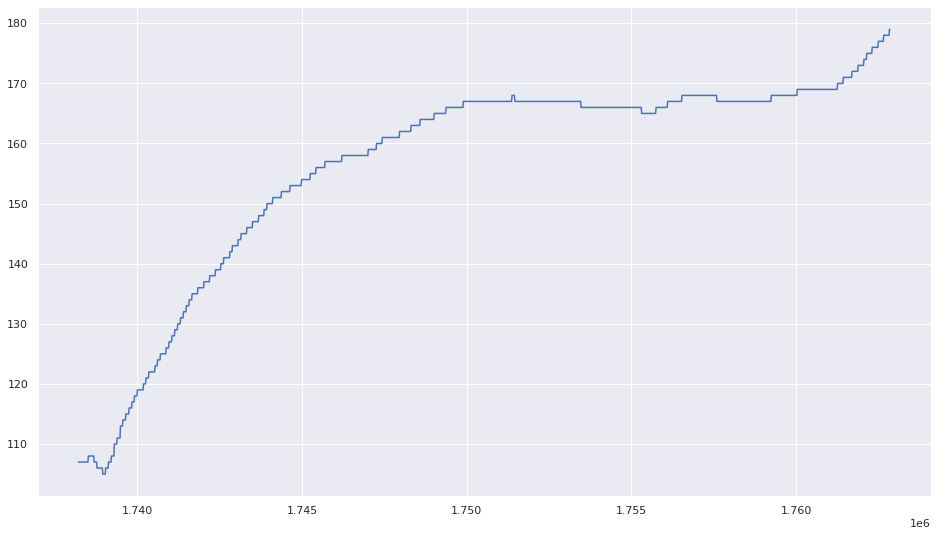

In [32]:
running_df["heartrate"].plot()

# Adding Heart Rate Zone Data

Another metric that is often used in determining exertion is that of heart rate zones. These can define exertion into one of 5 categories using a percentage of the user's maximum heart rate.

These categories and their percentages are:
1.   Very light	50–60%
2.   Light	60–70%
3.   Moderate	70–80%
4.   Hard	80–90%
5.   Maximum	90–100%

Included in the dataset is each subject's maximum heart rate, so this feature can be calculated as performed below.

In [33]:
max_heartrates = [193, 195, 189, 196, 194, 194, 197, 188, 189]
interp_df['max_heartrate'] = 0
for subID in range(1,10):
    interp_df['max_heartrate'].mask(interp_df['subject_id'] == subID, other = max_heartrates[subID-1], inplace=True)


interp_df["pct_max_hr"] = (interp_df["heartrate"]/interp_df["max_heartrate"])


interp_df['hr_zone'] = 0
zone = [0.5, 0.6, 0.7, 0.8, 0.9]
for zone_idx in range(1,6):
    interp_df['hr_zone'].mask(interp_df['pct_max_hr'] > zone[zone_idx-1], other = zone_idx, inplace=True)

interp_df.drop(columns=["max_heartrate","pct_max_hr"], inplace=True)

# Correlation Analysis

With the aim of determining each features utility, we can plot a graph showing how strongly each feature correlates with each other feature.

As can be seen in the plot below, category ID correlates stronger with the gyroscopic sensor from each IMU than it does with the accelerometer or magnetometer. It can also be seen that category ID correlates very strongly with heart rate. This indicates that it will be a useful feature in prediction. 

It is worth noting that these correlation values may be skewed as the dataset has not been normalised or scaled yet. The change in temperature values will be very low compared to the change in other features and as such it may be under representing its utility.

With the aim of creating actionable insights for a potential manufacturer, we would want to create an accurate model using a minimum of features, so that it is more production friendly in the sense that it is cheaper and easier to produce. The next correlation graphs look at specifically a watch wearable and a chest strap wearable.

It is also visible that heart rate zone correlates strongly with heart rate, and whilst this is obvious it does mean that this causes feature redundancy. The only utility of this feature would not be in activity category, but in measuring individual exertion in a specific activity.

In [34]:
target_cols = ["heartrate", "hr_zone", "categoryID",
               "handTemperature",
               "handAcc16_vecsum","handGyro_vecsum","handMagne_vecsum",
               "chestTemperature",
               "chestAcc16_vecsum", "chestGyro_vecsum", "chestMagne_vecsum",
               "ankleTemperature",
               "ankleAcc16_vecsum","ankleGyro_vecsum","ankleMagne_vecsum"]

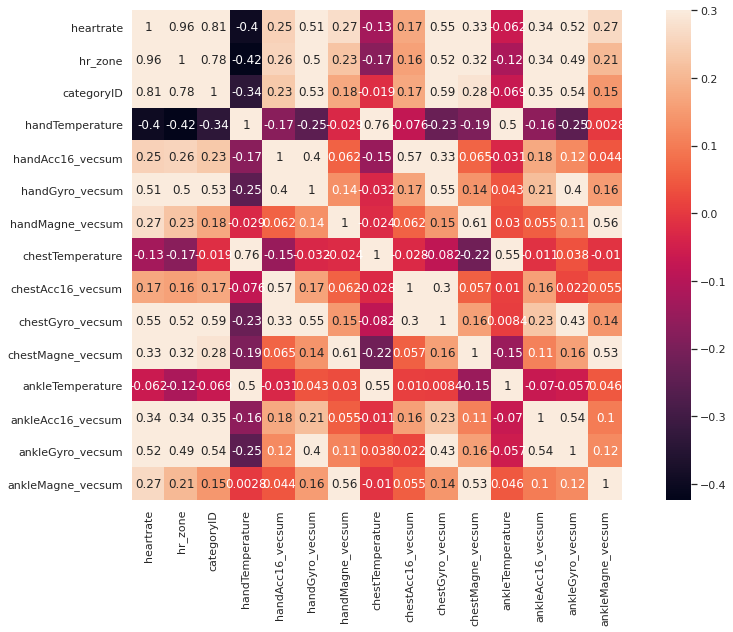

In [35]:
corr = interp_df[target_cols].corr()
ax = sns.heatmap(corr, vmax=.3, square=True, annot = True)

The below plot shows an example of a collection of features that could be gathered using only a wearable watch.

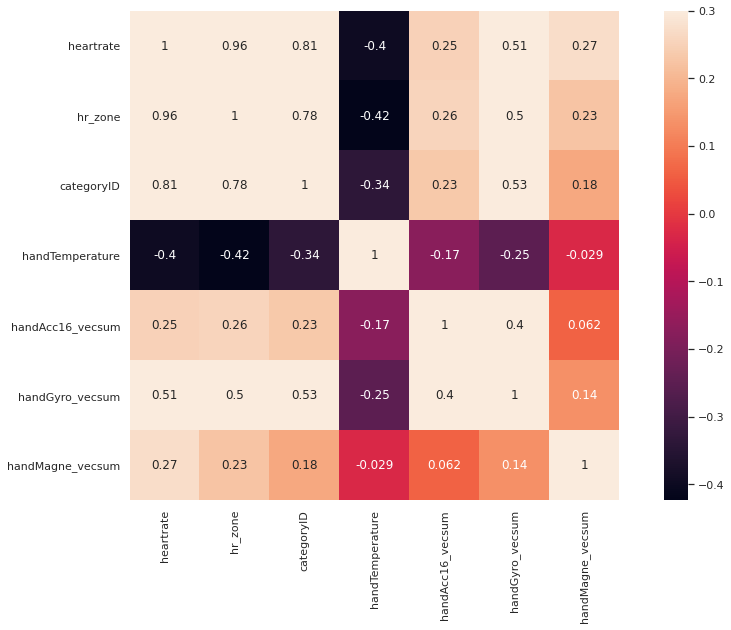

In [36]:
target_features = ['heartrate', 
                   "hr_zone", 
                   'categoryID', 
                   'handTemperature', 
                   'handAcc16_vecsum',
                   "handGyro_vecsum", 
                   'handMagne_vecsum']


corr = interp_df[target_features].corr()

ax = sns.heatmap(corr, vmax=.3, square=True, annot = True)

The below plot shows a list of features that could all be gathered using a wearable chest strap.

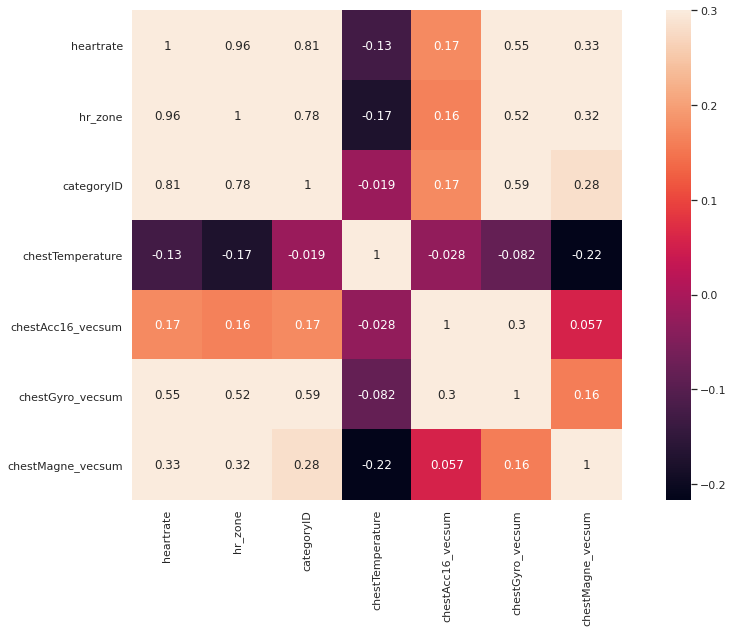

In [37]:
target_features = ['heartrate', 
                   "hr_zone", 
                   'categoryID', 
                   'chestTemperature', 
                   'chestAcc16_vecsum',
                   "chestGyro_vecsum", 
                   'chestMagne_vecsum']


corr = interp_df[target_features].corr()

ax = sns.heatmap(corr, vmax=.3, square=True, annot = True)

# Investigating Utility of Temperature

This section aims to validate the use of the temperature feature in model prediction. 
First we will look at a bar chart of the average temperatures per activity, and then we will look at the correlations between heart rate and temperature, by MET category of activity. 

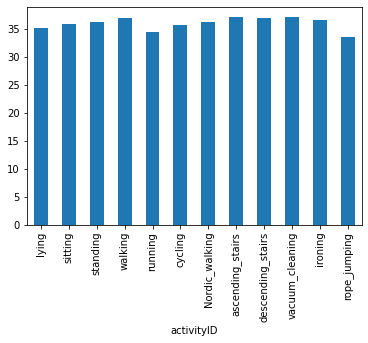

In [ ]:
df_temp = interp_df['chestTemperature'].groupby(interp_df['activityID']).mean()
df_temp.index = df_temp.index.map(activityIDdict)
df_temp.plot(kind='bar')

In the plot above, it can be seen that the highest MET value activities have, on average, the lowest temperatures (running, rope jumping). 
Intuitively, we can understand this as being due to the perspiration, and it indicates that it may serve as a useful feature for prediction.

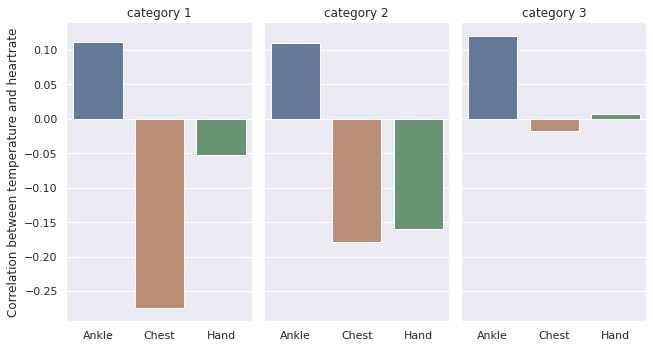

In [45]:
correlation_cols = ["heartrate", "ankleTemperature", "chestTemperature", "handTemperature"]

new_index = interp_df["activityID"].unique()

list_to_add = []

for actID in new_index:
    temp_corr_df = interp_df[interp_df["activityID"] == actID]
    correlation = temp_corr_df[correlation_cols].corr()
    correlation = correlation["heartrate"]

    for idx,row in correlation.iteritems():
        if idx != "heartrate":

            add_index = idx.replace("Temperature", "")

        if actID in moderate_actIDs:
            correlation["category"] = 2
            row_to_add = [row, add_index, 2]

        elif actID in vigourous_actIDs:
            correlation["category"] = 3
            row_to_add = [row, add_index, 3]

        else:
            correlation["category"] = 1
            row_to_add = [row, add_index, 1]

        list_to_add.append(row_to_add)


corr_columns = ["correlation", "location", "category"]

corr_df = pd.DataFrame(list_to_add)
corr_df.columns = corr_columns

g = sns.catplot(x="location", y="correlation", col="category",
                data=corr_df, saturation=.5,
                kind="bar", ci=None, aspect=.6)
(g.set_axis_labels("", "Correlation between temperature and heartrate")
  .set_xticklabels(["Ankle", "Chest", "Hand"])
  .set_titles("{col_var} {col_name}")
  .despine(left=True))


The plot above shows the correlation between temperature and heart rate at each sensor location, split by category.

The correlations achieved for each category are quite different, which would indicate that the temperature and heart rate features together can be a good indicator of category type.
Their dissimilarity makes them distinguishable. 

# Hypothesis testing



The hypothesis that we want to test is the one that states that there is mass difference in heart rate between category 2 and 3, and category 1 activities. The former are more exhausting than the latter and have higher MET values. 

To test this we will perform a ttest, where we will check that the average heart rate of category 2 and 3 is higher on most of the confidence interval than the heart rate of category 1 activities performed by the subjects.

In [40]:
import scipy.stats

#Testing hypothesis for exercise and non exercise (category 1 versus category 2&3)
category_1 = interp_df[interp_df["categoryID"] == 1]
category_2 = interp_df[interp_df["categoryID"] == 2]
category_3 = interp_df[interp_df["categoryID"] == 3]

exercise_category = category_2.append(category_3)

p = (exercise_category["heartrate"].mean() - category_1["heartrate"].mean()) / (exercise_category["heartrate"].std() / np.sqrt(exercise_category["heartrate"].count()))

pValue = 1 - scipy.stats.norm.cdf(p)

if pValue > 0.1:
    print("The p_value is ", pValue, " and h1 is rejected. There is no mass difference between the means of category 2 & 3 activities and category 1 activities.")
else:
    print("The p_value is ", pValue, " and h0 is rejected. There is mass difference between the means of category 2 & 3 activities and category 1 activities.")

The p_value is  0.0  and h0 is rejected. There is mass difference between the means of category 2 & 3 activities and category 1 activities.


# Model

The proposed model is a Logistic Regression. The features given to this model are shown below. There are 3 sets of features, one is for a theoretical chest strap wearable, one is for a watch style monitor, and the last set is to show the full accuracy potential if the model was trained on all the IMU data.

The idea behind testing multiple models is that it shows the trade off between model accuracy and hardware cost to produce. It would be impractical to ask a user to wear a monitor on the chest, hand, and ankle and so the model trained on that data is more of a control. The two proposed models are the most commonly used type of fitness hardware, watches and chest straps. 

For all of the sets of features, the model scales the data between -1 and 1 to remove bias towards larger/smaller features. The training data has had the activityID, subjectID, timestamp, categoryID features removed.

The accuracies achieved by the model with these features is consistently above 80% when predicting the category of exercise by MET.

In [ ]:
def get_predictions(evaluating_columns, prediction_column):
    """
    Given a set of columns to use for testing model,
    returns the predicted values as well as the true values for that data split.
    """
    eval_dataset = interp_df[evaluating_columns]

    train_df = eval_dataset.sample(frac=0.8, random_state=1)
    test_df = eval_dataset.drop(train_df.index)

    y_train = train_df[prediction_column].values
    y_test = test_df[prediction_column].values

    x_train = train_df.drop(['activityID','timestamp','subject_id', 'categoryID'], axis=1).values
    x_test = test_df.drop(['activityID','timestamp','subject_id', 'categoryID'], axis=1).values

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.fit_transform(x_test)

    log_reg = LogisticRegression()
    log_reg.fit(X=x_train_scaled, y=y_train )
    y_pred_lr = log_reg.predict(x_test_scaled)

    return y_test, y_pred_lr

In [ ]:
def get_metrics(y_true,y_pred):
    acc = accuracy_score(y_true, y_pred)
    err = 1-acc
    p = precision_score(y_true, y_pred,average=None).mean()
    r = recall_score(y_true, y_pred, average=None).mean()
    f1 = f1_score(y_true, y_pred, average=None).mean()
   
    print("Accuracy: ",acc)
    print("Error: ",acc)
    print("Precision", p)
    print("Recall", r)
    print("F1", f1)
    #print("Accuracy: %.3f \nError: %.3f \nPrecesion: %.3f \nRecall: %.3f \nF1:%.3f \n"% (acc,err,p,r,f1) )

In [ ]:
chest_model_features = ["heartrate",  "activityID", "timestamp", "subject_id", "categoryID","chestTemperature","chestGyro_vecsum"]
hand_model_features = ["heartrate",  "activityID", "timestamp", "subject_id", "categoryID","handTemperature","handGyro_vecsum"]

all_model_features = interp_df.columns

In [ ]:
#Training on just chest temp & gyro, and heart rate features
truth, predictions = get_predictions(chest_model_features, "activityID")
get_metrics(truth, predictions)

In [ ]:
#Training on just hand temp & gyro, and heart rate features
truth, predictions  = get_predictions(hand_model_features, "activityID")
get_metrics(truth, predictions)

In [ ]:
#Training on all features
truth, predictions = get_predictions(all_model_features, "activityID")
get_metrics(truth, predictions)

Potential Hardware Designs:
- Chest Model
 - This hardware could be a chest strap, and would only need the following sensors:
   - Heart rate monitor
   - Thermometer
   - Gyroscope
 - The proposed model has been trained with the above features using the chest IMU and can achieve:
 ```
Accuracy:  0.8648262621791474
Error:  0.8648262621791474
Precision 0.8592506367794904
Recall 0.7911132157107764
F1 0.8140315545663842
 ```

- Hand Model
 - This prototype could be a wearable piece of tech similar to a smart watch, and would only need to have the following sensors:
   - A heart rate monitor
   - A thermometer
   - A gyroscope

 - The proposed model was trained on the above features using the hand IMU data and is able to achieve:
 ```
 Accuracy:  0.8290467195437677
 Error:  0.8290467195437677
 Precision 0.8244280393705795
 Recall 0.7593887402504412
 F1 0.7813791251959034
 ```

- By contrast, a model that was trained on the entire dataset using features from each IMU was able to achieve:
 ```
Accuracy:  0.8981789826390855
Error:  0.8981789826390855
Precision 0.8799255037126598
Recall 0.825427484511286
F1 0.8451579495109399
 ```
